### 건강검진 결과 데이터에서 일상생활에서 쉽게 수집 가능한 신체 및 생활습관 지표를 기반으로, 당뇨병 고위험군 여부를 예측하는 분류 모델을 구축하는 것

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 힌글 폰트 사용을 위한 설정 (윈도우)
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font) # 폰트 전역 설정

# 1. 데이터 로드 및 전처리

<알아야 할 정보>
- 성별코드: 1(남자), 0(여자)
- 연령대코드: 

| 코드 | 연령대   | 코드 | 연령대    | 코드 | 연령대    | 코드 | 연령대    |
|------|----------|------|-----------|------|-----------|------|-----------|
| 1    | 0~4세    | 2    | 5~9세     | 3    | 10~14세  | 4    | 15~19세  |
| 5    | 20~24세  | 6    | 25~29세   | 7    | 30~34세   | 8    | 35~39세   |
| 9    | 40~44세  | 10   | 45~49세   | 11   | 50~54세   | 12   | 55~59세   |
| 13   | 60~64세  | 14   | 65~69세   | 15   | 70~74세   | 16   | 75~79세   |
| 17   | 80~84세  | 18   | 85세 이상 |      |           |      |           |

In [3]:
# 데이터 로드
medical_df = pd.read_csv('국민건강보험공단_건강검진정보_2023.csv', encoding='cp949')
medical_df.columns
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 33 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   기준년도           1000000 non-null  int64  
 1   가입자일련번호        1000000 non-null  int64  
 2   시도코드           1000000 non-null  int64  
 3   성별코드           1000000 non-null  int64  
 4   연령대코드(5세단위)    1000000 non-null  int64  
 5   신장(5cm단위)      1000000 non-null  int64  
 6   체중(5kg단위)      1000000 non-null  int64  
 7   허리둘레           999589 non-null   float64
 8   시력(좌)          999816 non-null   float64
 9   시력(우)          999823 non-null   float64
 10  청력(좌)          999863 non-null   float64
 11  청력(우)          999862 non-null   float64
 12  수축기혈압          994253 non-null   float64
 13  이완기혈압          994253 non-null   float64
 14  식전혈당(공복혈당)     994186 non-null   float64
 15  총콜레스테롤         338606 non-null   float64
 16  트리글리세라이드       338606 non-null   float64
 17  HDL콜레스테롤 

## 1.1 불필요한 특성 제거
 - 일상생활에서 스스로 파악하거나 일반적으로 수집하기 용이하지 않은 특성 제거

In [4]:
required_medical_df = medical_df[['가입자일련번호','기준년도','연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)',
 '허리둘레', '수축기혈압', '이완기혈압', '흡연상태', '음주여부', '식전혈당(공복혈당)']]

## 1.2. BMI 특성 생성

In [5]:
required_medical_df['BMI'] = required_medical_df['체중(5kg단위)'] / ((required_medical_df['신장(5cm단위)'] / 100) ** 2)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_2308\3342067277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_medical_df['BMI'] = required_medical_df['체중(5kg단위)'] / ((required_medical_df['신장(5cm단위)'] / 100) ** 2)


## 1.3. 공복 혈당 기준으로 당뇨 '정상' 및 '위험'군으로 라벨링 
- 라벨링 완료 후 '식전혈당(공복혈당)' 컬럼은 제거 (분류 근거 출처 달아야 함)

In [6]:
#required_medical_df['당뇨_위험여부'] = np.where(required_medical_df['식전혈당(공복혈당)']>=100, '정상', '주의')
required_medical_df.loc[required_medical_df['식전혈당(공복혈당)']>=100, '당뇨_위험여부'] = '위험'
required_medical_df.loc[required_medical_df['식전혈당(공복혈당)']<100, '당뇨_위험여부'] = '정상'

# 본 혈당수치 컬럼 제거
#required_medical_df = required_medical_df.drop('식전혈당(공복혈당)', axis=1)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_2308\3652780538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  required_medical_df.loc[required_medical_df['식전혈당(공복혈당)']>=100, '당뇨_위험여부'] = '위험'


## 1.3. 데이터 구조 및 기초 통계 확인

In [7]:
required_medical_df.head(5)

,가입자일련번호,기준년도,연령대코드(5세단위),성별코드,신장(5cm단위),체중(5kg단위),허리둘레,수축기혈압,이완기혈압,흡연상태,음주여부,식전혈당(공복혈당),BMI,당뇨_위험여부
0,34735,2023,9,2,155,70,92.0,139.0,89.0,1.0,1.0,98.0,29.136316,정상
1,4105118,2023,17,1,160,55,86.0,123.0,52.0,1.0,1.0,87.0,21.484375,정상
2,362482,2023,13,2,150,65,96.0,109.0,69.0,1.0,1.0,114.0,28.888889,위험
3,653166,2023,13,1,160,70,85.0,116.0,64.0,3.0,1.0,98.0,27.343750,정상
4,4152237,2023,12,1,165,65,84.5,137.0,86.0,3.0,1.0,105.0,23.875115,위험


In [8]:
required_medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   가입자일련번호      1000000 non-null  int64  
 1   기준년도         1000000 non-null  int64  
 2   연령대코드(5세단위)  1000000 non-null  int64  
 3   성별코드         1000000 non-null  int64  
 4   신장(5cm단위)    1000000 non-null  int64  
 5   체중(5kg단위)    1000000 non-null  int64  
 6   허리둘레         999589 non-null   float64
 7   수축기혈압        994253 non-null   float64
 8   이완기혈압        994253 non-null   float64
 9   흡연상태         999911 non-null   float64
 10  음주여부         999944 non-null   float64
 11  식전혈당(공복혈당)   994186 non-null   float64
 12  BMI          1000000 non-null  float64
 13  당뇨_위험여부      994186 non-null   object 
dtypes: float64(7), int64(6), object(1)
memory usage: 106.8+ MB


In [9]:
required_medical_df.describe()

,가입자일련번호,기준년도,연령대코드(5세단위),성별코드,신장(5cm단위),체중(5kg단위),허리둘레,수축기혈압,이완기혈압,흡연상태,음주여부,식전혈당(공복혈당),BMI
count,1.000000e+06,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999589.000000,994253.000000,994253.000000,999911.000000,999944.000000,994186.000000,1000000.000000
mean,2.499892e+06,2023.0,10.598531,1.484965,162.683560,64.334995,81.322400,122.971086,75.425795,1.543575,0.659812,100.696463,24.158500
std,1.443348e+06,0.0,3.046639,0.499774,9.348951,13.864438,10.858057,14.635007,10.307323,0.788110,0.473772,22.985404,3.951718
min,3.000000e+00,2023.0,5.000000,1.000000,130.000000,30.000000,7.500000,65.000000,10.000000,1.000000,0.000000,13.000000,10.380623
25%,1.250397e+06,2023.0,8.000000,1.000000,155.000000,55.000000,74.000000,113.000000,69.000000,1.000000,0.000000,89.000000,21.484375
50%,2.500716e+06,2023.0,11.000000,1.000000,165.000000,65.000000,81.000000,122.000000,75.000000,1.000000,1.000000,96.000000,23.875115
75%,3.749801e+06,2023.0,13.000000,2.000000,170.000000,75.000000,88.000000,132.000000,82.000000,2.000000,1.000000,106.000000,26.159334
max,5.000000e+06,2023.0,18.000000,2.000000,195.000000,135.000000,999.000000,261.000000,181.000000,3.000000,1.000000,930.000000,60.000000


## 1.4. 결측치 처리
- 개개인의 상태를 기반으로 해야하는 예측이기 때문에, 모든 결측치가 하나라도 있는 행은 전부 제거 

In [10]:
required_medical_df = required_medical_df.dropna()

In [11]:
required_medical_df.isnull().sum()

가입자일련번호        0
기준년도           0
연령대코드(5세단위)    0
성별코드           0
신장(5cm단위)      0
체중(5kg단위)      0
허리둘레           0
수축기혈압          0
이완기혈압          0
흡연상태           0
음주여부           0
식전혈당(공복혈당)     0
BMI            0
당뇨_위험여부        0
dtype: int64

# 2. EDA

## 2.1. 타켓 분포 확인

<Axes: xlabel='당뇨_위험여부'>

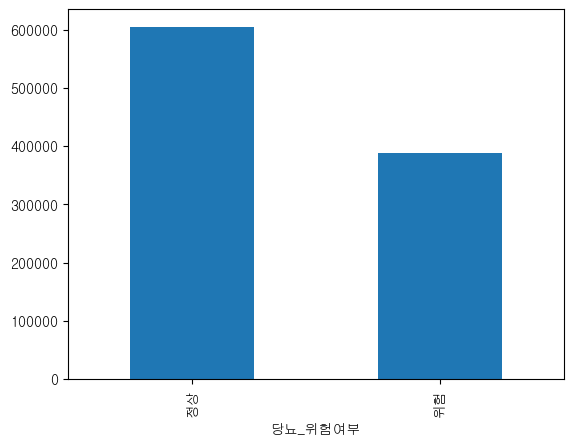

In [12]:
required_medical_df['당뇨_위험여부'].value_counts().plot(kind='bar')

# 2.1. 수치형 Feature 간 상관관계

<Axes: >

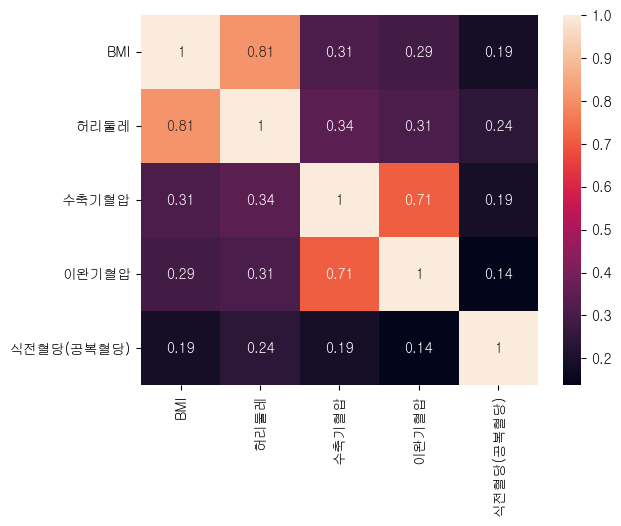

In [13]:
sns.heatmap(required_medical_df[['BMI', '허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)']].corr(), annot=True)

- 공복혈당(당뇨 위험군 구분 기준)은 다른 변수들과 약한 상관만을 보이며, 독립적인 예측 요인이 될 수 있음
- = 머신러닝 모델로 예측 시 여러 변수들의 비선형 조합이 도움이 될 수 있다는 걸 시사

## 2.2. 당뇨 위험 여부에 따른 BMI 분포 비교

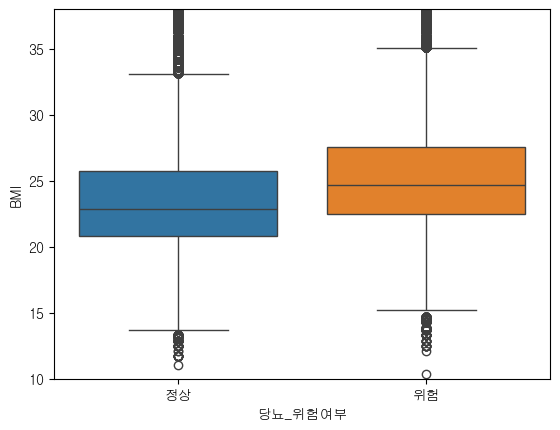

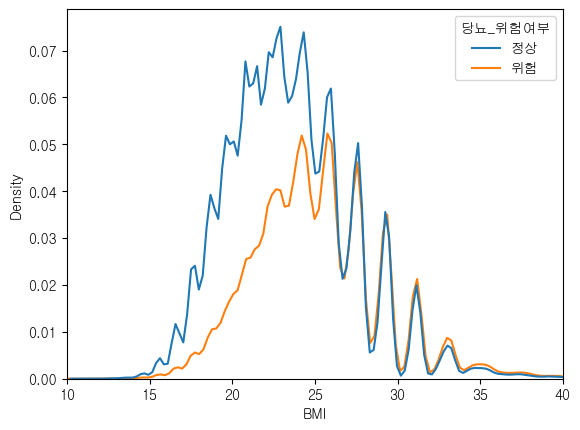

In [14]:
sns.boxplot(x='당뇨_위험여부', y='BMI', data=required_medical_df, hue='당뇨_위험여부')
plt.ylim(10, 38)  # 중심 분포만 보여줌
plt.show()

#히스토그램/커널 밀도 추정 (KDE)
sns.kdeplot(data=required_medical_df, x='BMI', hue='당뇨_위험여부')
plt.xlim(10,40)
plt.show()

위험군이 BMI 값이 더 높은 경향을 보이는 것 확인 가능

## 2.3. 혈압 vs 공복 혈당

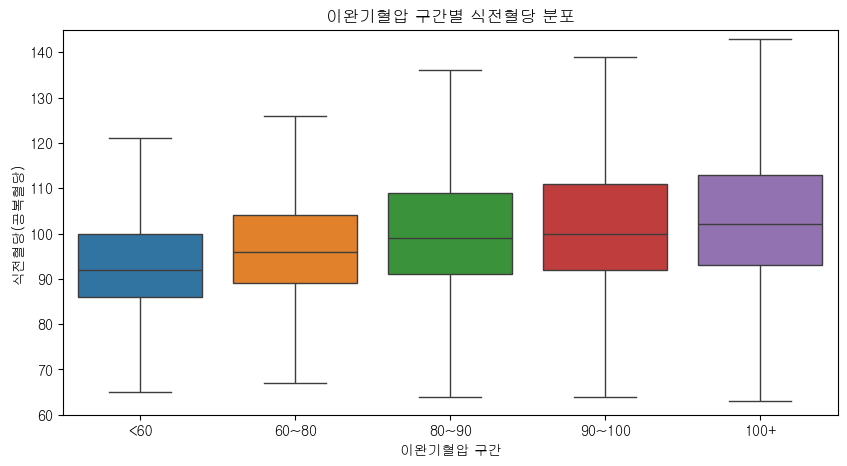

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 이완기혈압 구간 정의 및 라벨링
required_medical_df['이완기혈압구간'] = pd.cut(
    required_medical_df['이완기혈압'],
    bins=[0, 60, 80, 90, 100, 200],
    labels=['<60', '60~80', '80~90', '90~100', '100+']
)

# 시각화
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=required_medical_df,
    x='이완기혈압구간',
    y='식전혈당(공복혈당)',
    hue='이완기혈압구간', 
    showfliers=False       # 이상치 숨기기
)

plt.title('이완기혈압 구간별 식전혈당 분포')
plt.xlabel('이완기혈압 구간')
plt.ylabel('식전혈당(공복혈당)')
plt.ylim(60, 145)
plt.show()


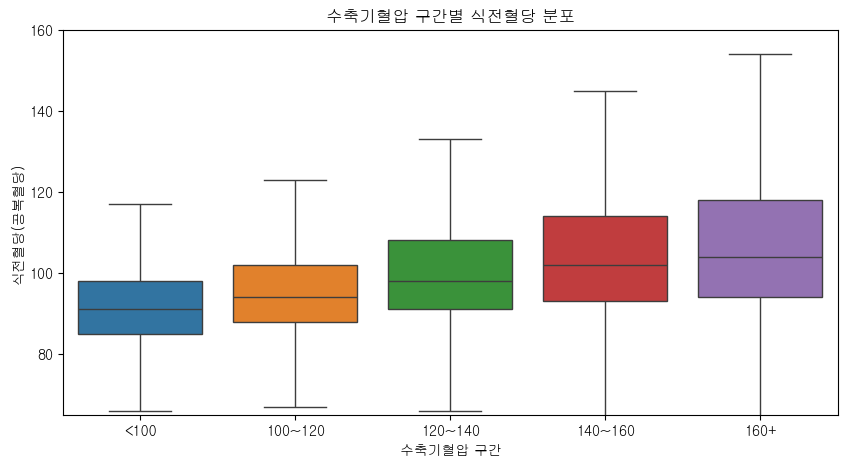

In [63]:
required_medical_df['혈압구간'] = pd.cut(required_medical_df['수축기혈압'], bins=[0, 100, 120, 140, 160, 300],
                                     labels=['<100', '100~120', '120~140', '140~160', '160+'])

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=required_medical_df, 
    x='혈압구간', 
    y='식전혈당(공복혈당)', 
    hue='혈압구간',
    showfliers=False  # 이상치 숨김
    )
plt.title('수축기혈압 구간별 식전혈당 분포')
plt.xlabel('수축기혈압 구간')
plt.ylabel('식전혈당(공복혈당)')
plt.ylim(65,160)
plt.show()

혈압이 높아질수록 식전혈당도 높아지는 경향성 확인

# 2.4. 당뇨 위험 여부에 따른 허리둘레 분포 비교

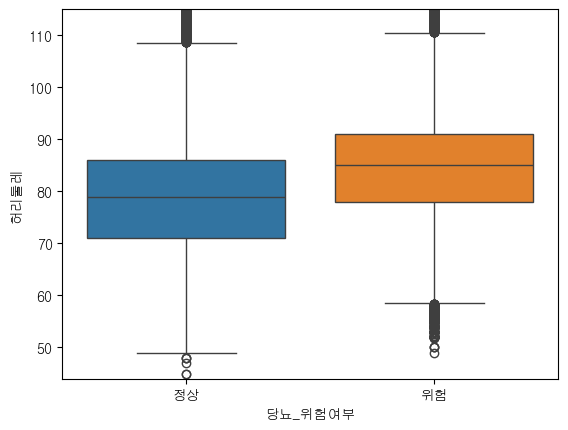

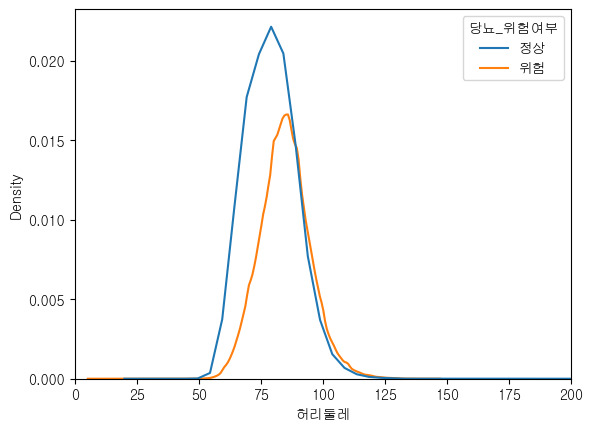

In [15]:
## 2.2. 당뇨 위험 여부에 따른 BMI 분포 비교
sns.boxplot(x='당뇨_위험여부', y='허리둘레', data=required_medical_df, hue='당뇨_위험여부')
plt.ylim(44, 115)  # 중심 분포만 보여줌
plt.show()

#히스토그램/커널 밀도 추정 (KDE)
sns.kdeplot(data=required_medical_df, x='허리둘레', hue='당뇨_위험여부')
plt.xlim(0,200)
plt.show()

당뇨 위험군이 허리둘레가 더 높은 경향 확인 가능

## 2.5. 범주형 특성 vs 타겟

### 2.5.1. 흡연과 혈당(당뇨)

**흡연상태 따른 당뇨 위험군 분포**

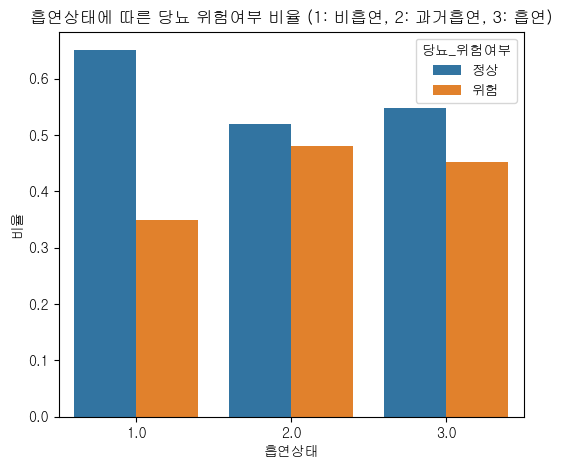

In [49]:
# 교차표 (비율)
alcohol_ratio = (
    required_medical_df.groupby('흡연상태')['당뇨_위험여부']
    .value_counts(normalize=True)
    .rename('비율')
    .reset_index()
)

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(data=alcohol_ratio, x='흡연상태', y='비율', hue='당뇨_위험여부')
plt.title("흡연상태에 따른 당뇨 위험여부 비율 (1: 비흡연, 2: 과거흡연, 3: 흡연)")
plt.ylabel("비율")
plt.show()


한번도 흡연 한 적 없는 사람보다 한 적 있는 사람이 더 당뇨에 취약한 성향 가지는 경향 확인

**흡연상태과 혈당의 통계적 유의성**

In [22]:
from scipy.stats import f_oneway

# 흡연상태: 1(비흡연), 2(과거흡연), 3(현재흡연)

# 각 그룹별 데이터 나누기
group1 = required_medical_df[required_medical_df['흡연상태'] == 1]['식전혈당(공복혈당)']
group2 = required_medical_df[required_medical_df['흡연상태'] == 2]['식전혈당(공복혈당)']
group3 = required_medical_df[required_medical_df['흡연상태'] == 3]['식전혈당(공복혈당)']

# ANOVA 수행
f_stat, p_value = f_oneway(group1, group2, group3)

# 결과 출력
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value:.5f}")

# 해석
if p_value < 0.005:
    print("흡연상태에 따라 식전혈당 평균이 유의하게 다름.")
else:
    print("흡연상태에 따라 식전혈당 평균에 유의한 차이가 없음.")


F-statistic: 5728.212
p-value: 0.00000
흡연상태에 따라 식전혈당 평균이 유의하게 다름.


### 2.5.2. 음주와 혈당(당뇨)

**음주여부 vs 당뇨 위험 여부**

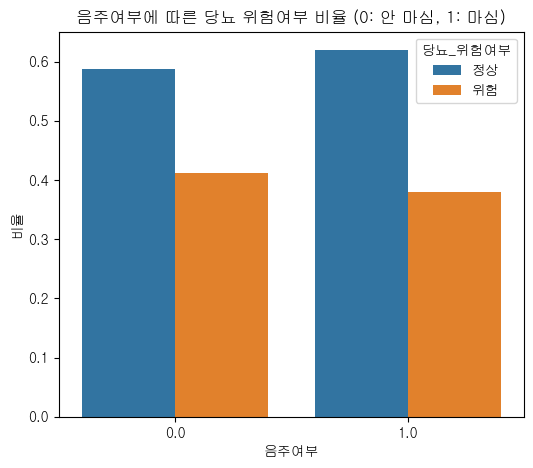

In [35]:
# 교차표 (비율)
alcohol_ratio = (
    required_medical_df.groupby('음주여부')['당뇨_위험여부']
    .value_counts(normalize=True)
    .rename('비율')
    .reset_index()
)

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(data=alcohol_ratio, x='음주여부', y='비율', hue='당뇨_위험여부')
plt.title("음주여부에 따른 당뇨 위험여부 비율 (0: 안 마심, 1: 마심)")
plt.ylabel("비율")
plt.show()


**음주여부와 공복혈당의 통계적 유의성**

In [37]:
from scipy.stats import ttest_ind

# 음주여부: 0(마시지 않는다), 1(마신다)

# 두 그룹으로 나누기
group_0 = required_medical_df[required_medical_df['음주여부'] == 0]['식전혈당(공복혈당)']
group_1 = required_medical_df[required_medical_df['음주여부'] == 1]['식전혈당(공복혈당)']

# 독립표본 t-검정 (Welch’s t-test 사용-> 각 그룹의 표본 수나 분산이 다를 수 있기 때문에
t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)  

print(f't-stat: {t_stat:.3f}, p-value: {p_value:.3f}')

# 해석
if p_value < 0.005:
    print("음주여부에 따라 식전혈당 평균이 유의하게 다름.")
else:
    print("음주여부에 따라 식전혈당 평균에 유의한 차이가 없음.")


t-stat: 34.965, p-value: 0.000
음주여부에 따라 식전혈당 평균이 유의하게 다름.


### 2.5.3. 성별과 혈당(당뇨)

**성별 vs 혈당 (당뇨 위험여부)**

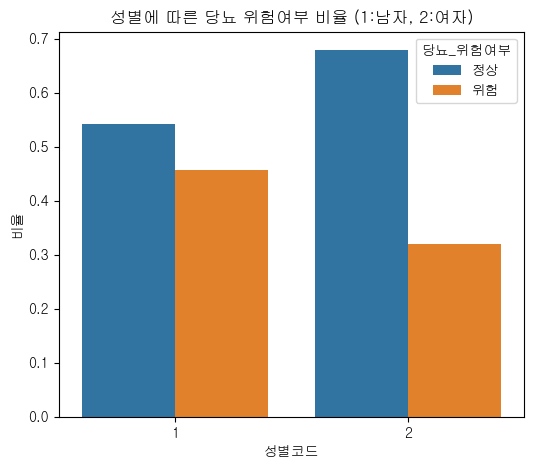

In [34]:
# 교차표 (비율)
gender_ratio = (
    required_medical_df.groupby('성별코드')['당뇨_위험여부']
    .value_counts(normalize=True)
    .rename('비율')
    .reset_index()
)

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(data=gender_ratio, x='성별코드', y='비율', hue='당뇨_위험여부')
plt.title("성별에 따른 당뇨 위험여부 비율 (1:남자, 2:여자)")
plt.ylabel("비율")
plt.show()

**성별과 공복혈당의 통계적 유의성**

In [ ]:
# 성별코드: 1(남자), 2(여자)

# 성별 기준 그룹 나누기
male = required_medical_df[required_medical_df['성별코드'] == 1]['식전혈당(공복혈당)']
female = required_medical_df[required_medical_df['성별코드'] == 2]['식전혈당(공복혈당)']

# 독립표본 t-검정 (Welch’s t-test 사용)
t_stat, p_value = ttest_ind(male, female, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

if p_value < 0.05:
    print("성별에 따라 식전혈당 평균이 유의하게 다릅니다.")
else:
    print("성별에 따른 식전혈당 평균 차이는 유의하지 않습니다.")


t-statistic: 129.594
p-value: 0.00000
성별에 따라 식전혈당 평균이 유의하게 다릅니다.


### 2.5.4. 연령대와 혈당(당뇨)

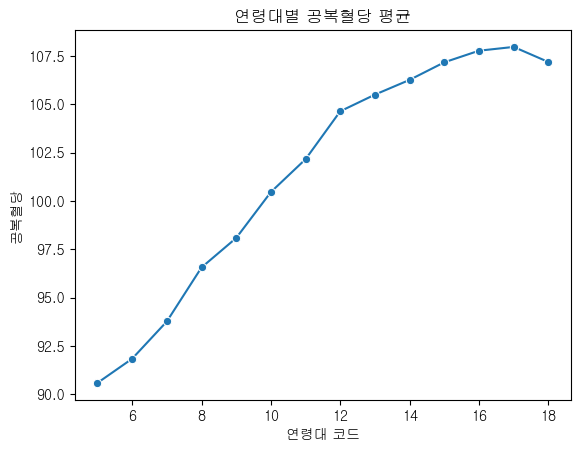

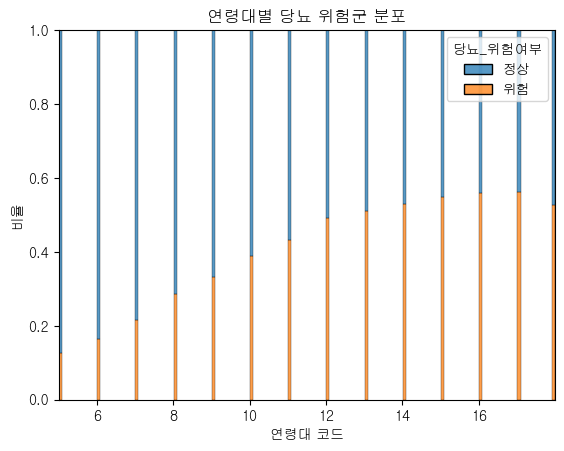

In [ ]:
# 연령대별 '평균' 공복혈당
mean_blood_sugar = required_medical_df.groupby('연령대코드(5세단위)')['식전혈당(공복혈당)'].mean().reset_index()
sns.lineplot(data=mean_blood_sugar, x='연령대코드(5세단위)', y='식전혈당(공복혈당)', marker='o')
plt.title("연령대별 공복혈당 평균")
plt.xlabel("연령대 코드")
plt.ylabel("공복혈당")
plt.show()

# 위험군 비율 막대그래프
sns.histplot(data=required_medical_df, x='연령대코드(5세단위)', hue='당뇨_위험여부', multiple='fill', shrink=0.8)
plt.title("연령대별 당뇨 위험군 분포")
plt.ylabel("비율")
plt.xlabel("연령대 코드")
plt.show()


**연령대와 혈당의 통계적 유의미성**

In [ ]:
from scipy.stats import f_oneway

# 연령대코드가 있는지 확인
#print(required_medical_df['연령대코드(5세단위)'].unique())  # 예: 1~18

# 연령대별 혈당 데이터 그룹화
grouped_data = [
    group['식전혈당(공복혈당)'].dropna()
    for _, group in required_medical_df.groupby('연령대코드(5세단위)')
    if len(group) > 1  # 샘플이 2개 이상인 경우만 사용
]

# ANOVA 수행
f_stat, p_value = f_oneway(*grouped_data)

print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value:.5f}")

# 해석
if p_value < 0.005:
    print("연령대에 따라 식전혈당 평균이 유의하게 다릅니다.")
else:
    print("연령대에 따라 식전혈당 평균에 유의한 차이가 없습니다.")

F-statistic: 4112.873
p-value: 0.00000
연령대에 따라 식전혈당 평균이 유의하게 다릅니다.


<통계 결과 추정>
- 노화에 따라 인슐린 저항성이 증가하면서 혈당 조절이 어려워질 수 있음.
- 생활 습관의 변화 (식습관, 활동량 감소 등)가 혈당 수치에 영향을 미칠 수 있음.

---

## 모델에 사용할 데이터셋 (이걸로 모델 학습시킵니다)

In [70]:
required_medical_df = required_medical_df.drop(['혈압구간','이완기혈압구간'], axis=1)

In [78]:
required_medical_df.to_csv('kr_national_health_dataset.csv', index=False)